# Simulating Content Personalization with Contextual Bandits

In [74]:
from vowpalwabbit import pyvw
import random
import matplotlib.pylab as plt

## Simulating reward for Vowpal Wabbit

In [75]:
# VW tries to minimize loss/cost, therefore we willl pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [76]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

## Understanding Vowpal Wabbit format

In [77]:
# This function modifies (context, action, cost, prob) wo VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string = "shared |User user={} time_of_time={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={}\n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [78]:
context = {"user":"Tom","time_of_day":"morning"}
actions = {"politics", "sports", "music", "food"}

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_time=morning
|Action article=sports
|Action article=music
|Action article=politics
|Action article=food


## Getting a decision from Vowpal Wabbit

In [79]:
def sample_custom_pmf(pmf): 
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf] # normalization
    draw = random.random()  # what's the point/purpose of draw ?
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

We have all the information we need to choose an action for a specific user and context. Use Vowpal Wabbit to achieve this with the following steps:

* Convert the context and actions into the text format needed.
* Pass this example to Vowpal Wabbit and get the PMF output.
* Sample this PMF to get the article to show.
* Return the chosen article and the probability of choosing it. 

In [80]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

## Reinforcement learning simulation

In [81]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

#### Instantiate learner

We instantiate a contextual bandit learner in Vowpal Wabbit and then simulate Tom and Anna’s website visits **num_iterations** number of times. With each visit, we do the following:

1. Decide between Tom and Anna
2. Decide the time of day
3. Pass context (i.e., user, time of day) to the learner to get action (i.e., article recommendation, and the probability of choosing action).
4. Receive reward (i.e., see if the user clicked or not). Remember that cost is just a negative reward.
5. Format context, action, probability, reward in Vowpal Wabbit format
6. Learn from the example


In [82]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)

    return ctr
# Note: finish_example is important as it updates statistics and frees used memory.

#### Visulization 

In [83]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

## First scenario

#### With learning

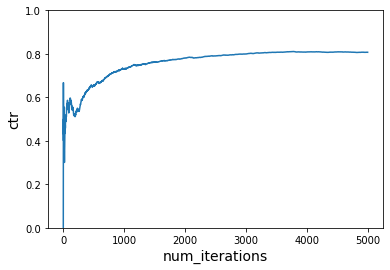

In [84]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

#### Interations

If we didn’t include `-q UA`, the learning would not work. We can see that in the following action:

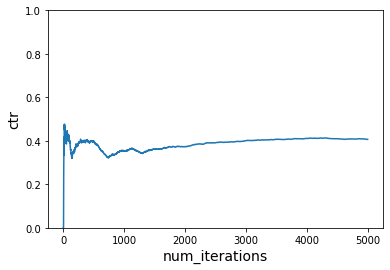

In [85]:
# Instantiate learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

#### Without learning

Let’s do the same thing again, but with -q. This step shows the effect if we don’t learn from what happens. The CTR never improves, and we hover around 0.2.



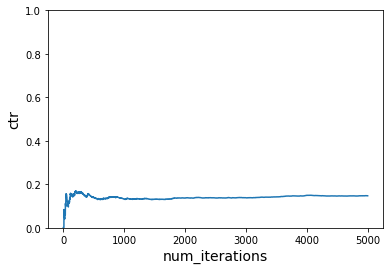

In [86]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, do_learn=False)

plot_ctr(num_iterations, ctr)

# Second scenario

People’s preferences change over time in the real world. To account for this in the simulation, we incorporate two different cost functions and swap over to the second one halfway through.

### Tom

| | `get_cost` | `get_cost_new1` |
|:---|:---:|:---:|
| **Morning** | Politics | Politics |
| **Afternoon** | Music | Sports |

### Anna

| | `get_cost` | `get_cost_new1`  |
|:---|:---:|:---:|
| **Morning** | Sports | Sports |
| **Afternoon** | Politics | Sports |

In [87]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

To make it easy to show the effect of the cost function changing, we modify the run_simulation function. It is a little less readable, but it supports accepting a list of cost functions, and it operates over each cost function in turn.

In [88]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

#### With learning

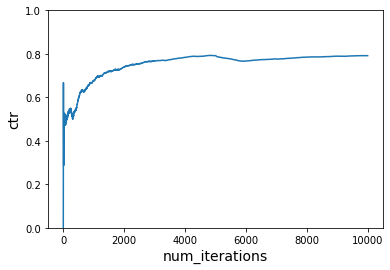

In [92]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)
# Note: The initial spike in CTR depends on the rewards received for the first few examples. When you run on your own, you may see something different initially because our simulator is designed to have randomness.

#### Without learning

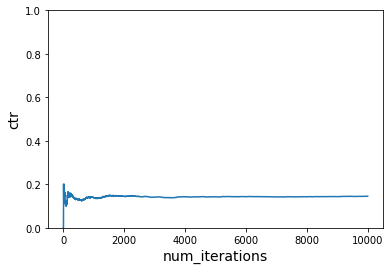

In [94]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

## Third scenario

In the final scenario, we start rewarding actions that have never seen a reward previously when we change the cost function:

### Tom

| | `get_cost` | `get_cost_new2` |
|:---|:---:|:---:|
| **Morning** | Politics |  Politics|
| **Afternoon** | Music |   Food |

### Anna

| | `get_cost` | `get_cost_new2` |
|:---|:---:|:---:|
| **Morning** | Sports | Food|
| **Afternoon** | Politics |  Food |

In [95]:
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

#### With learning

Now, we switch to the third reward function after a few samples (running the first reward function). Remember that this reward function changes the preferences of the users. It is working with a different action space than before. We should see the learner pick up these changes and optimize the new preferences.

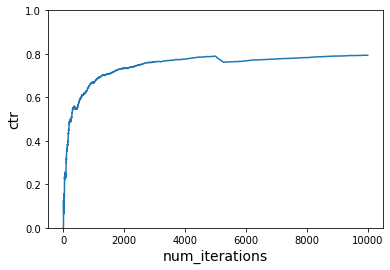

In [105]:
# use first reward function initially and then switch to third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### Without learning

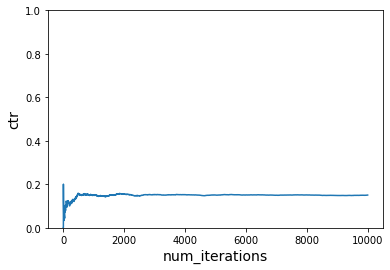

In [98]:
# Do not learn
# use first reward function initially and then switch to third reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)

plot_ctr(total_iterations, ctr)

# Summary
This contextual bandit tutorial showcases a real-world simulation scenario for using the contextual bandit approach to reinforcement learning. We take a context and a set of actions and learn what actions worked best for a given context. The result is that the learner responds rapidly to real-world changes. We showed that allowing the learner to interact with the world resulted in higher rewards than the “without learning” baseline.

This tutorial worked with simplistic features. VW supports high dimensional sparse features, different exploration algorithms and policy evaluation approaches.